Download colab_utils and import



<a href="https://colab.research.google.com/github/beangoben/gnn_workshop_riiaa/blob/master/Prediccion de Nodos con Arxiv MAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [1]:
!wget https://raw.githubusercontent.com/beangoben/gnn_workshop_riiaa/master/colab_utils.py -O colab_utils.py
!rm -rf sample_data
import colab_utils

--2021-08-25 10:34:34--  https://raw.githubusercontent.com/beangoben/gnn_workshop_riiaa/master/colab_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7173 (7.0K) [text/plain]
Saving to: ‘colab_utils.py’

colab_utils.py      100%[===================>]   7.00K  --.-KB/s    in 0s      

2021-08-25 10:34:35 (38.2 MB/s) - ‘colab_utils.py’ saved [7173/7173]



Clone github repo, install stuff

In [4]:
github_repo = 'https://github.com/beangoben/gnn_workshop_riiaa'
colab_utils.clone_repo(github_repo)

CMD: git clone --recursive https://github.com/beangoben/gnn_workshop_riiaa
pip installing ['tensorflow-probability', 'dm-sonnet', 'graph_nets', 'umap-learn', 'littleballoffur', 'ogb']
CMD: pip install  tensorflow-probability
CMD: pip install  dm-sonnet
CMD: pip install  graph_nets
Created wheel for graph-nets: filename=graph_nets-1.1.0-cp36-none-any.whl size=91866 sha256=91c715b8a21de61d8e5a6c8ca1c179964869d97a31e672c50266030af7b211db
Stored in directory: /root/.cache/pip/wheels/c9/85/dc/ad3c616f83f0774ff12d6d7599850f56d82976e8590e59e864
Successfully built graph-nets
CMD: pip install  umap-learn
CMD: pip install  littleballoffur
Created wheel for littleballoffur: filename=littleballoffur-1.0.4-cp36-none-any.whl size=33047 sha256=bb90bb466e83685ce3908dd575d823ffe6362991e044615a68fe0924a77ee70e
Stored in directory: /root/.cache/pip/wheels/59/3e/98/95534e2901381b6f5ae951fe983780f856bab9ca4a082056e7
Created wheel for networkit: filename=networkit-7.0-cp36-cp36m-linux_x86_64.whl size=714344

# Import modules


In [6]:
import os
from collections import OrderedDict, defaultdict

import tqdm.auto as tqdm
import colab_utils 

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import networkx as nx

import sklearn
import umap
import tensorflow as tf
import sonnet as snt
import graph_nets as gn
import ogb

colab_utils.print_module_versions([umap, tf, snt, nx, ogb])
print(f'Tiene GPU? {tf.config.list_physical_devices("gpu")}')
colab_utils.matplotlib_settings()

umap      : 0.4.6
tensorflow: 2.3.0
sonnet    : 2.0.0
networkx  : 2.4
ogb       : 1.2.2
Tiene GPU? []


## Bajar dataset (arxiv)

In [7]:
from ogb.nodeproppred import NodePropPredDataset

dataset = NodePropPredDataset(name = 'ogbn-arxiv')
dataset

  0%|          | 0/81 [00:00<?, ?it/s]

Downloaded 0.08 GB: 100%|██████████| 81/81 [00:02<00:00, 33.11it/s]


Extracting dataset/arxiv.zip
Loading necessary files...
This might take a while.


100%|██████████| 1/1 [00:00<00:00, 2048.00it/s]

Processing graphs...
Saving...


NodePropPredDataset(1)

In [8]:
dataset.meta_info[['ogbn-arxiv']]

,ogbn-arxiv
add_inverse_edge,False
additional edge files,None
additional node files,node_year
download_name,arxiv
eval metric,acc
has_edge_attr,False
has_node_attr,True
is hetero,False
num classes,40
num tasks,1


## Data-wrangling

In [10]:
def get_topk_labels(dataset, k=10):
    """Conserguir las categorias mas pobladas."""
    unique, counts = np.unique(dataset.labels.ravel(), return_counts=True)
    sorted_labels = np.argsort(counts)[::-1]
    
    adf = pd.read_csv(os.path.join('dataset/ogbn_arxiv/mapping', 'labelidx2arxivcategeory.csv.gz'), compression="gzip")
    label_to_category = dict(zip(adf['label idx'], adf['arxiv category']))
    top_labels = sorted_labels[:k]
    return top_labels, [label_to_category[i] for i in top_labels]

top_labels, categories = get_topk_labels(dataset, 10)
N_LABELS = len(top_labels)
top_labels, categories

(array([16, 24, 28, 30, 10, 34,  8,  4,  5,  2]),
 ['arxiv cs cv',
  'arxiv cs lg',
  'arxiv cs it',
  'arxiv cs cl',
  'arxiv cs ai',
  'arxiv cs ds',
  'arxiv cs ni',
  'arxiv cs cr',
  'arxiv cs dc',
  'arxiv cs lo'])

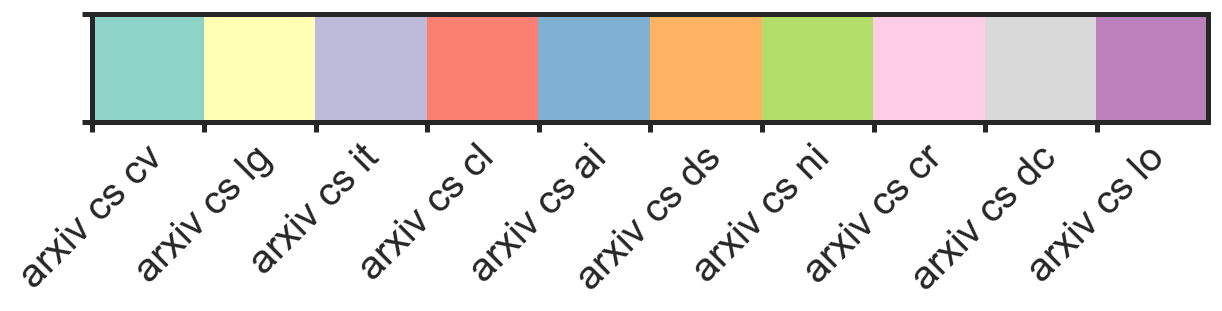

In [ ]:
def labels_to_nodecolors(labels, k=10):
    """Convierte etqiuetas a colores."""
    cols = sns.color_palette("Set3", k)
    return [cols[int(l)] for l in labels.ravel()]

def plot_color_legend(k=10):
    cols = sns.color_palette("Set3", k)
    sns.palplot(cols)
    plt.xticks(np.arange(N_LABELS)-0.5, categories, rotation=45)
    plt.show()
    
plot_color_legend()

## Construir train-test split

In [11]:
def make_arxiv_subset(dataset, split, label_subset=None, large_cc=True):
    """Get a split of the arxiv dataset"""

    n_edges = dataset.graph['edge_index'].shape[1]
    n_nodes = dataset.graph['node_feat'].shape[0]
    data_dict = {
        'nodes':dataset.graph['node_feat'].astype(np.float32),
        'edges':np.zeros((n_edges, 1),dtype=np.float32),
        'senders':dataset.graph['edge_index'][0],
        'receivers':dataset.graph['edge_index'][1],
        'globals':np.zeros(1,dtype=np.float32),
    }
    y = dataset.labels
    # Get paper ids
    adf = pd.read_csv(os.path.join('dataset/ogbn_arxiv/mapping', 'nodeidx2paperid.csv.gz'), compression="gzip")
    paperids = adf['paper id'].values
    # Convert to networkx
    g = gn.utils_np.data_dict_to_networkx(data_dict)

    # Subset by indices
    indices = dataset.get_idx_split()[split]
    y = y[indices]
    paperids = paperids[indices]
    g = g.subgraph(indices)
    g = nx.relabel.convert_node_labels_to_integers(g)
    print(len(indices), y.shape, len(g.nodes))

    # Subset by labels
    if label_subset is not None:
        is_top = np.isin(y.ravel(), top_labels)
        top_indices = np.arange(len(g.nodes))[is_top]
        y = y[top_indices]
        g = g.subgraph(top_indices)
        g = nx.relabel.convert_node_labels_to_integers(g)
        paperids = paperids[top_indices]

    # Get largest component.
    if large_cc:
        gcc = list(sorted(nx.connected_components(g.to_undirected()), key=len, reverse=True)[0])
        print(len(gcc), np.max(gcc), len(y))
        g = g.subgraph(gcc)
        g = nx.relabel.convert_node_labels_to_integers(g)
        y = y[gcc]
        paperids = paperids[gcc]
    
    # relabel labels to 0 to n-labels
    new_labels = {j:i for i,j in enumerate(label_subset)}
    y = np.array([new_labels[i] for i in y.ravel()]).reshape(-1,1)
    return g, y, paperids

g_train, y_train, paperids_train = make_arxiv_subset(dataset, 'train', top_labels, True)
g_valid, y_valid, paperids_valid = make_arxiv_subset(dataset, 'valid', top_labels, False)

print(len(g_train.nodes), len(y_train), len(paperids_train))
print(len(g_valid.nodes), len(y_valid), len(paperids_valid))

90941 (90941, 1) 90941
90941 61670 (61670, 1) 61670
55428 61669 61670
29799 (29799, 1) 29799
29799 22021 (22021, 1) 22021
55428 55428 55428
22021 22021 22021


## Adentro de los datos

In [ ]:
data_dict = gn.utils_np.networkx_to_data_dict(g_train)
data_dict

{'nodes': array([[-0.057943, -0.05253 , -0.072603, ...,  0.173364, -0.172796,
         -0.140059],
        [-0.1245  , -0.070665, -0.325202, ...,  0.068524, -0.372111,
         -0.301036],
        [-0.080242, -0.023328, -0.183787, ...,  0.109919,  0.117589,
         -0.139883],
        ...,
        [-0.174095,  0.154307, -0.055722, ...,  0.086033, -0.068124,
         -0.093581],
        [-0.023307, -0.229567, -0.225063, ...,  0.069553, -0.062467,
         -0.058181],
        [-0.046241,  0.118672, -0.090002, ...,  0.014217,  0.056506,
         -0.099904]], dtype=float32),
 'edges': array([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]], dtype=float32),
 'receivers': array([15446, 44685, 35235, ..., 15539, 15125, 26147], dtype=int32),
 'senders': array([ 5138, 35109, 35109, ..., 40271, 40271, 53214], dtype=int32),
 'globals': array([0.], dtype=float32),
 'n_node': 55428,
 'n_edge': 272227}

In [ ]:
import sklearn.pipeline
import sklearn.preprocessing

node_info = data_dict['nodes']
print(node_info.shape)

pipe = sklearn.pipeline.Pipeline([('scaler', sklearn.preprocessing.StandardScaler()),
                                  ('dim_reduce', umap.UMAP())])
node_umap = pipe.fit_transform(node_info)
print(node_umap.shape)


(55428, 128)
(55428, 2)


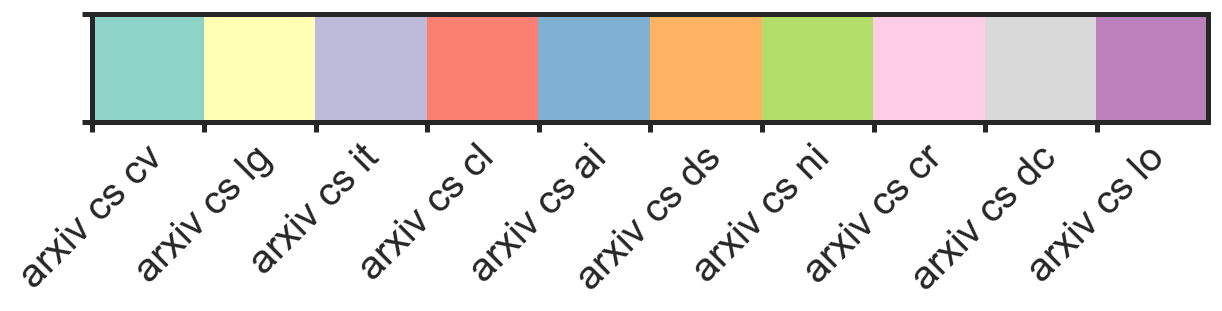

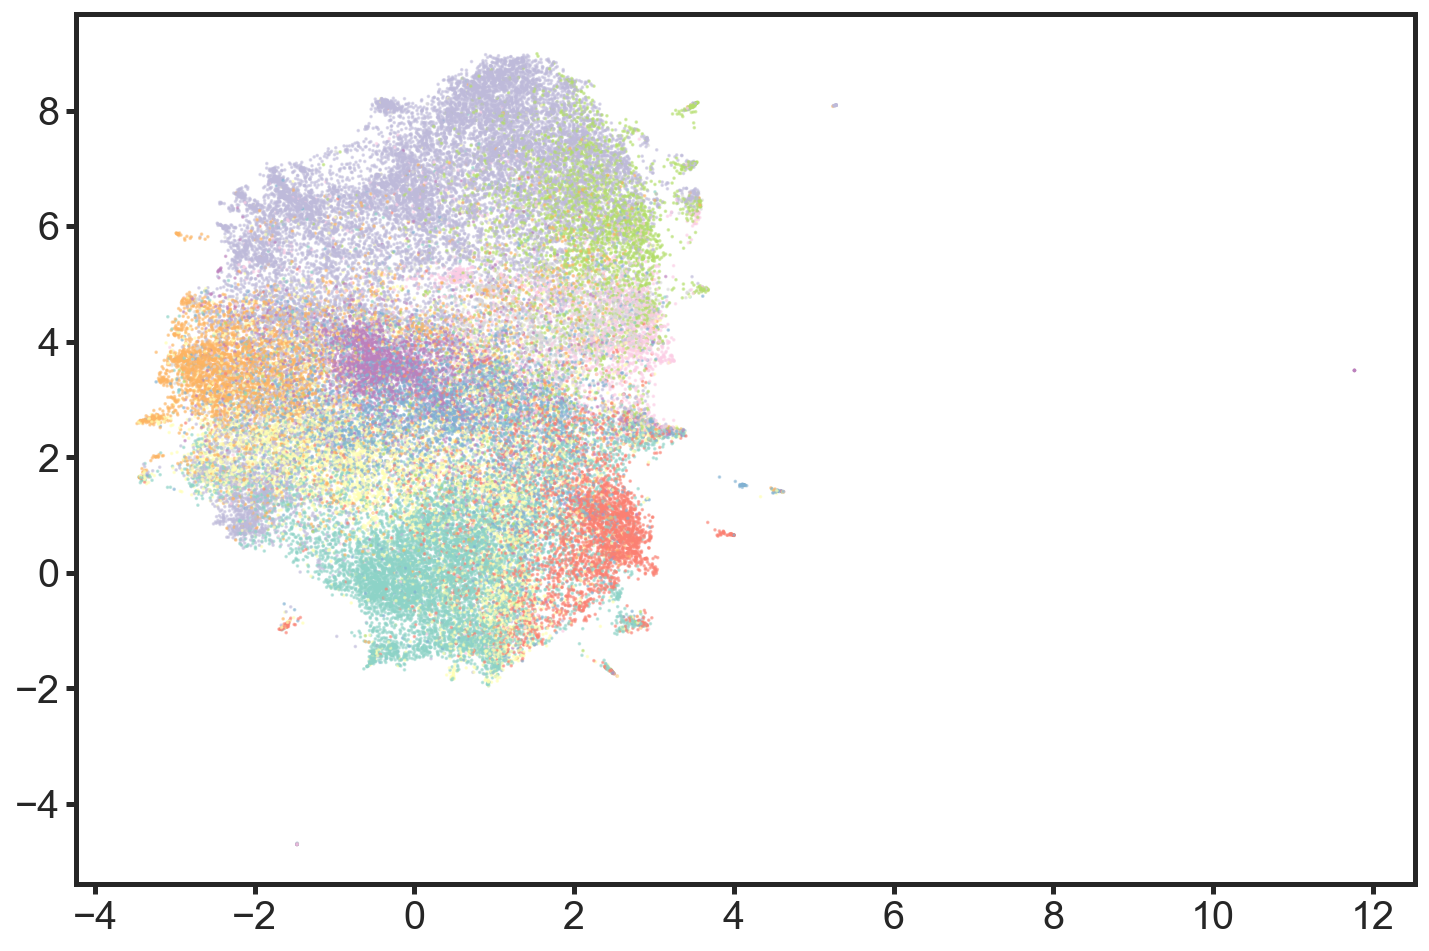

In [ ]:
plot_color_legend()
plt.scatter(node_umap[:,0], node_umap[:, 1],
            c=labels_to_nodecolors(y_train),
            s=1, alpha=0.5)
plt.show()

## Interactivo

In [ ]:
indices = np.random.permutation(len(node_umap))[:5000]

vis_df = pd.DataFrame()
vis_df['UMAP1'] = node_umap[indices, 0]
vis_df['UMAP2'] = node_umap[indices, 1]
vis_df['label'] = y_train[indices].ravel()
vis_df['id'] = paperids_train[indices]
vis_df

,UMAP1,UMAP2,label,id
0,-1.836624,3.250212,5,2745218150
1,1.780286,0.795786,0,1518487245
2,2.056294,3.072679,6,2738919153
3,0.311306,7.817774,2,2524816501
4,0.662448,8.457751,5,2950467063
...,...,...,...,...
4995,2.404086,-1.655255,0,2742520564
4996,-0.621624,4.105836,9,2950632841
4997,-0.327644,5.669375,2,2403448027
4998,1.516791,-0.804438,3,2584185835


In [ ]:
alt.Chart(vis_df).mark_circle(size=10).encode(
    x='UMAP1:Q',
    y='UMAP2:Q',
    color='label:N',
    tooltip=['id', 'label']
).interactive()

alt.Chart(...)

## Vamos a crear mini-batches de grafos

In [ ]:
from littleballoffur import MetropolisHastingsRandomWalkSampler
graph_sampler = MetropolisHastingsRandomWalkSampler(128)

In [ ]:
def get_batch():
    """Sub-samplea el graph."""
    batch_undirected = graph_sampler.sample(g_train.to_undirected())
    batch_index = list(batch_undirected.nodes)
    g_batch = g_train.subgraph(batch_index)
    g_batch = nx.relabel.convert_node_labels_to_integers(g_batch)
    y_batch = y_train[batch_index].ravel()
    return g_batch, y_batch

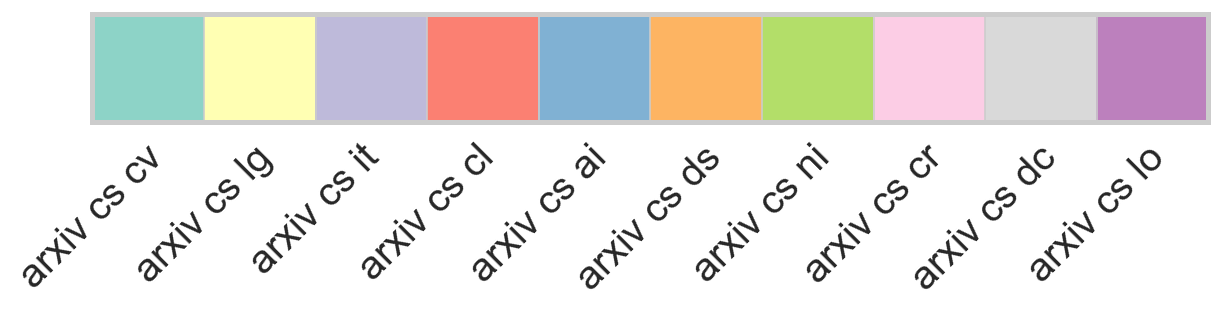

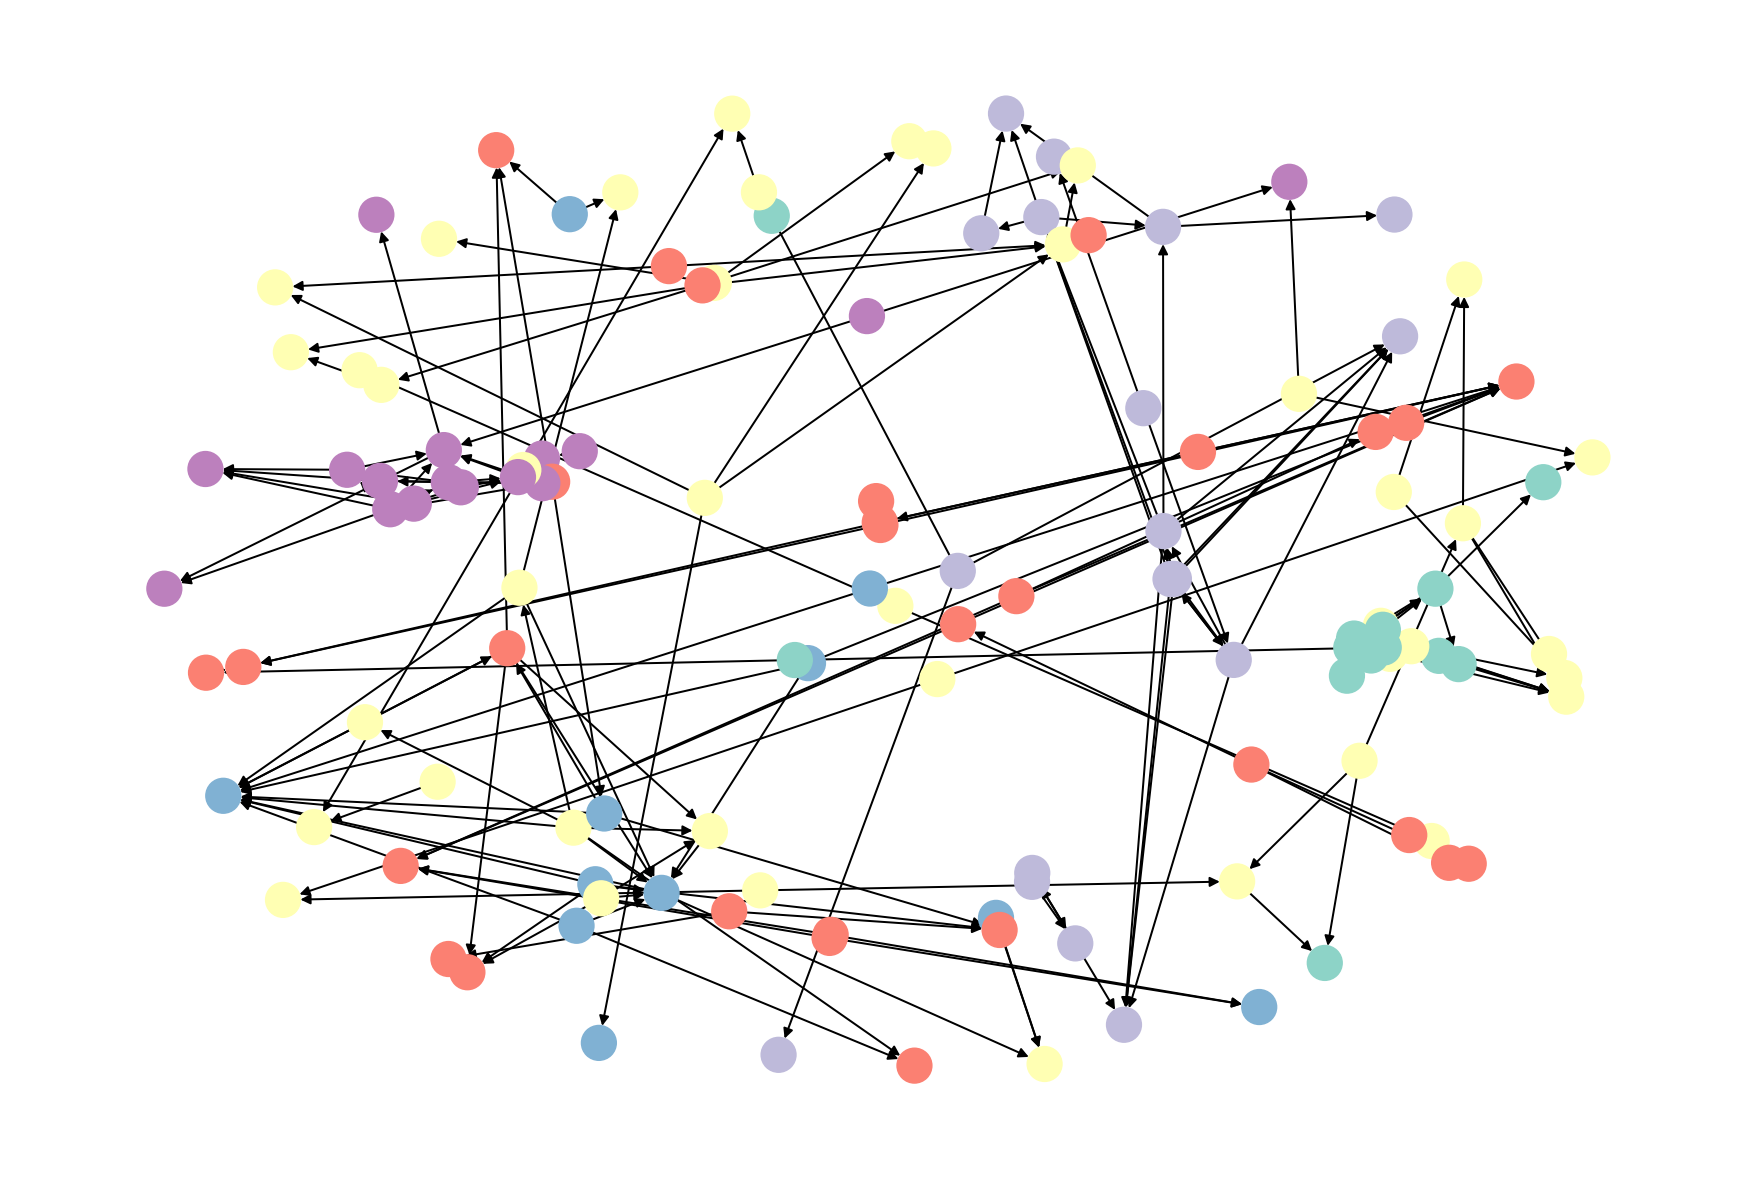

In [ ]:
g_batch, y_batch = get_batch()
plot_color_legend()
nx.draw(g_batch, nose_size=1, node_color=labels_to_nodecolors(y_batch))

# Nuestro grafo en tensorflow: GraphsTuple

In [ ]:
def nx_to_graph_stuple(g):
    """Convierte networkx a un GraphsTuple"""
    return gn.utils_tf.data_dicts_to_graphs_tuple([gn.utils_np.networkx_to_data_dict(g)])

In [ ]:
x_train = nx_to_graph_stuple(g_train)
x_valid = nx_to_graph_stuple(g_valid)
x_batch = nx_to_graph_stuple(g_batch)

In [ ]:
# Aplanamos los labels
y_train = y_train.ravel()
y_valid = y_valid.ravel()
print(y_train.shape, y_valid.shape)

(55428,) (22021,)


# Nuestro primer GNN

In [ ]:
def get_num_parameters(model: snt.Module, trainable: bool = True) -> int:
  """Numero de parametros."""
  variables = model.trainable_variables if trainable else model.variables
  return int(np.sum([np.prod(v.shape) for v in variables]))


def print_model(model: snt.Module):
  """Sumario de un modelo."""
  print(f'{model.__class__.__name__} : {model.name}\n')
  print(snt.format_variables(model.variables))
  n_params = get_num_parameters(model, False)
  trainable_params = get_num_parameters(model, True)
  print(f'\nParams: {trainable_params} trainable out of {n_params}')

## Bloque de transformacion

In [ ]:
def make_mlp_model(latent_size=32, n_layers=2, add_head=0):
    """Crea un MLP luego pasando por un LayerNorm y opcionalmente una capa lineal."""
    layers = [
        snt.nets.MLP([latent_size] * n_layers, activate_final=True),
        snt.LayerNorm(axis=-1, create_offset=True, create_scale=True)]
    if add_head > 0:
        layers.append(snt.Linear(add_head))
    return snt.Sequential(layers)
    
bloque = make_mlp_model(32, 2, 0)
bloque(x_batch.nodes)
print_model(bloque)

Sequential : sequential

| Variable          | Spec        | Trainable   | Device   |
|-------------------+-------------+-------------+----------|
| layer_norm/offset | f32[32]     | True        | CPU      |
| layer_norm/scale  | f32[32]     | True        | CPU      |
| mlp/linear_0/w    | f32[128,32] | True        | CPU      |
| mlp/linear_0/b    | f32[32]     | True        | CPU      |
| mlp/linear_1/w    | f32[32,32]  | True        | CPU      |
| mlp/linear_1/b    | f32[32]     | True        | CPU      |

Params: 5248 trainable out of 5248


# Un GNN independiente

In [ ]:
gnn = gn.modules.GraphIndependent(node_model_fn=lambda: make_mlp_model(32, 2, N_LABELS))
x_batch = nx_to_graph_stuple(g_batch)
out = gnn(x_batch)
print_model(gnn)

GraphIndependent : graph_independent

| Variable                                       | Spec        | Trainable   | Device   |
|------------------------------------------------+-------------+-------------+----------|
| graph_independent/node_model/layer_norm/offset | f32[32]     | True        | CPU      |
| graph_independent/node_model/layer_norm/scale  | f32[32]     | True        | CPU      |
| graph_independent/node_model/linear/w          | f32[32,10]  | True        | CPU      |
| graph_independent/node_model/linear/b          | f32[10]     | True        | CPU      |
| graph_independent/node_model/mlp/linear_0/w    | f32[128,32] | True        | CPU      |
| graph_independent/node_model/mlp/linear_0/b    | f32[32]     | True        | CPU      |
| graph_independent/node_model/mlp/linear_1/w    | f32[32,32]  | True        | CPU      |
| graph_independent/node_model/mlp/linear_1/b    | f32[32]     | True        | CPU      |

Params: 5578 trainable out of 5578


# A Entrenar !

In [ ]:
NUM_ITER = 100
optimizer = tf.optimizers.Adam(3e4)
metric = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
@tf.function(experimental_relax_shapes=True)
def forward_pass(x):
    """Prediccion."""
    out_x = gnn(x)
    return out_x.nodes

def logits_to_stats(y_true, node_logits):
    """Convert predicted logits to class stats."""
    loss = loss_fn(y_true, node_logits)
    probs = tf.nn.softmax(node_logits)
    acc = metric(y_true, probs).numpy()
    return loss.numpy(), acc

In [ ]:
pbar = tqdm.tqdm(range(NUM_ITER))
stats = defaultdict(list)

for i in pbar:
    with tf.GradientTape() as tape:
      node_logits = forward_pass(x_train)
      loss = loss_fn(y_train, node_logits)
    grads = tape.gradient(loss, gnn.trainable_variables)
    optimizer.apply_gradients(zip(grads, gnn.trainable_variables))
    # Train statistics.
    train_loss, train_acc = logits_to_stats(y_train, node_logits)
    stats['train_loss'].append(train_loss)
    stats['train_acc'].append(train_acc)
    # Validation statistics.
    node_logits = forward_pass(x_valid)
    valid_loss, valid_acc = logits_to_stats(y_valid, node_logits)
    stats['valid_loss'].append(valid_loss)
    stats['valid_acc'].append(valid_acc)
    # Update progress bar.
    pbar.set_postfix({key:values[-1] for key, values in stats.items()})
    

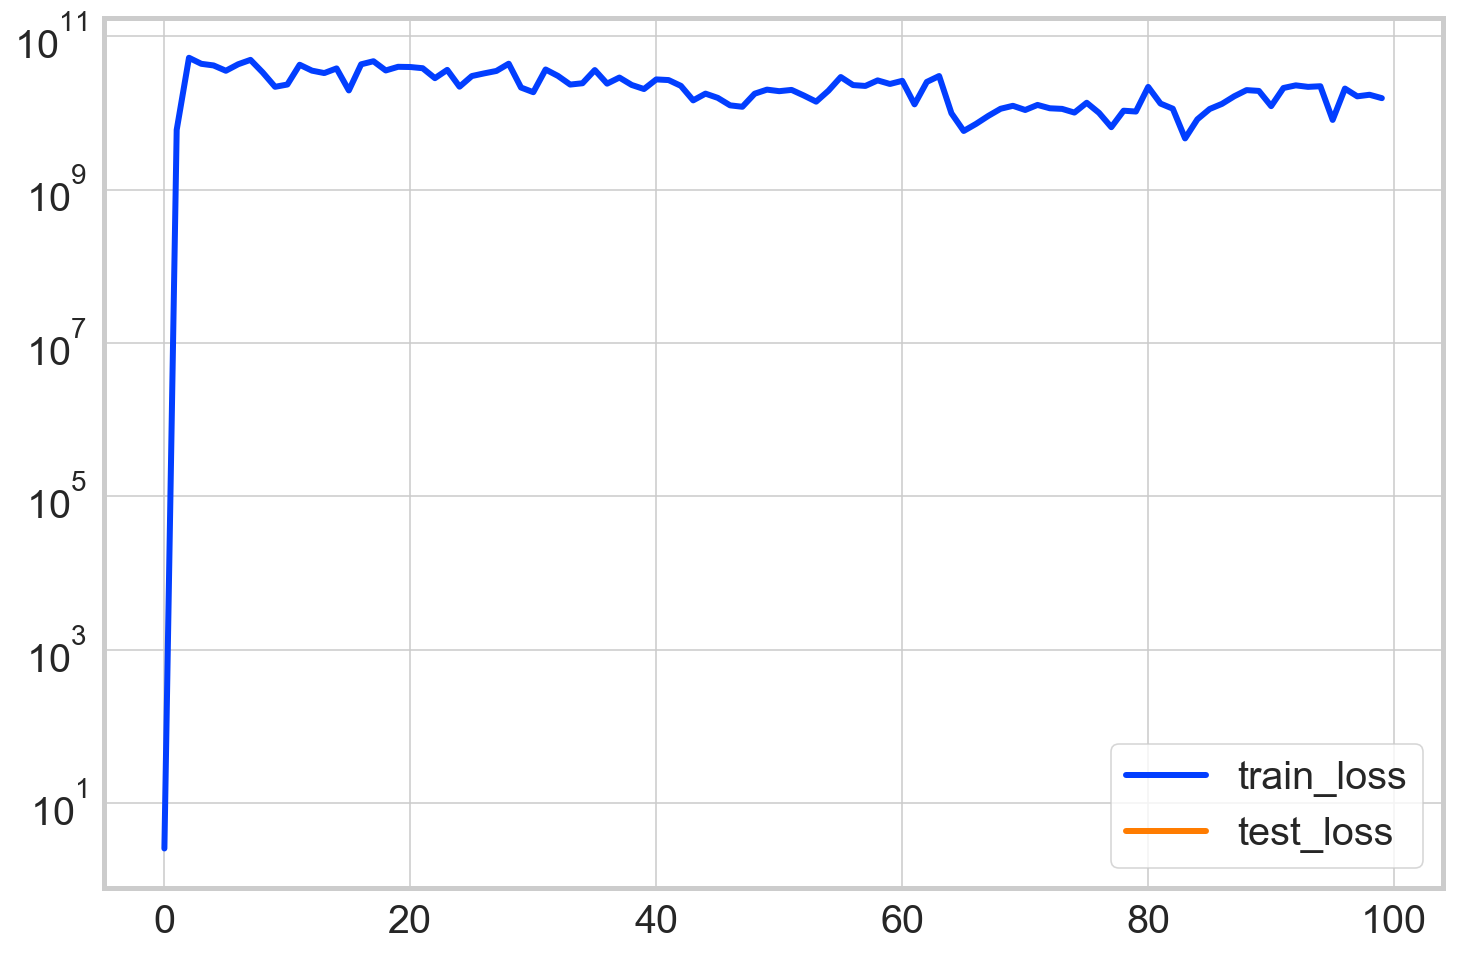

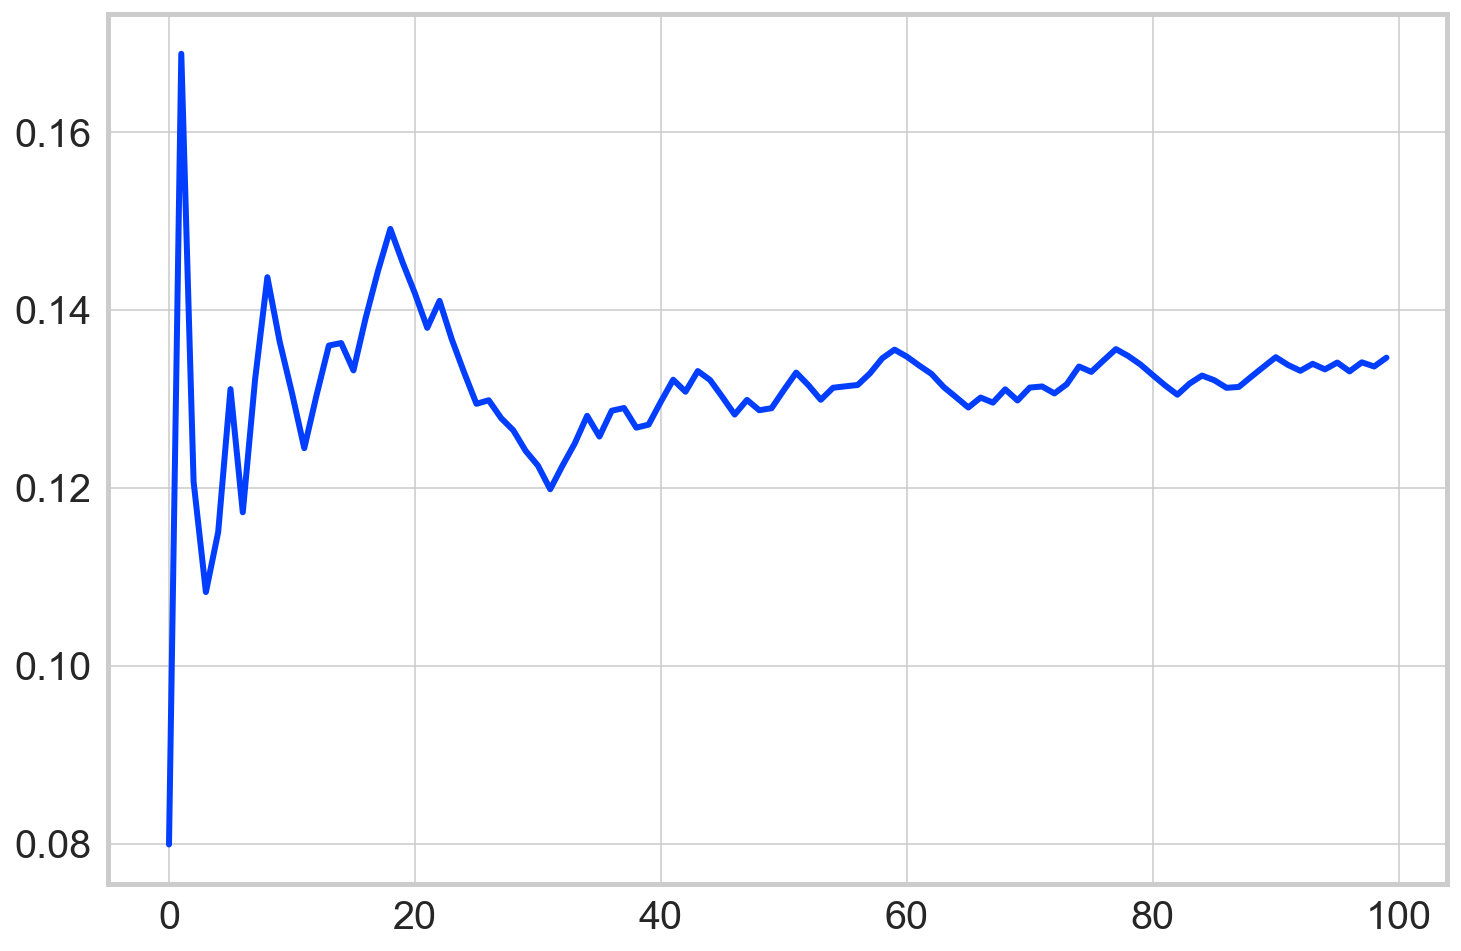

In [ ]:
for key in ['train_loss','test_loss']:
    plt.plot(stats[key],label=key)
plt.yscale('log')
plt.legend()
plt.show()

for key in ['train_acc','test_acc']:
    plt.plot(stats[key],label=key)
plt.show()

## GNN: GraphNets

In [ ]:
cabeza = gn.modules.GraphIndependent(
    node_model_fn=lambda: make_mlp_model(32, 2, N_LABELS))

gnn_layers = [gn.modules.GraphNetwork(
    edge_model_fn=lambda: make_mlp_model(32, 2),
    node_model_fn=lambda: make_mlp_model(32, 2),
    global_model_fn=lambda: make_mlp_model(32, 2)) for i in range(3)]

gnn = snt.Sequential( gnn_layers + [cabeza])
x_batch = nx_to_graph_stuple(g_batch)
out = gnn(x_batch)
print_model(gnn)

Sequential : sequential

| Variable                                       | Spec        | Trainable   | Device   |
|------------------------------------------------+-------------+-------------+----------|
| graph_independent/node_model/layer_norm/offset | f32[32]     | True        | CPU      |
| graph_independent/node_model/layer_norm/scale  | f32[32]     | True        | CPU      |
| graph_independent/node_model/linear/w          | f32[32,10]  | True        | CPU      |
| graph_independent/node_model/linear/b          | f32[10]     | True        | CPU      |
| graph_independent/node_model/mlp/linear_0/w    | f32[32,32]  | True        | CPU      |
| graph_independent/node_model/mlp/linear_0/b    | f32[32]     | True        | CPU      |
| graph_independent/node_model/mlp/linear_1/w    | f32[32,32]  | True        | CPU      |
| graph_independent/node_model/mlp/linear_1/b    | f32[32]     | True        | CPU      |
| graph_network/edge_block/layer_norm/offset     | f32[32]     | True      

In [ ]:
NUM_ITER = 100
optimizer = tf.optimizers.Adam(3e4)
metric = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
@tf.function(experimental_relax_shapes=True)
def forward_pass(x):
    """Prediccion."""
    out_x = gnn(x)
    return out_x.nodes

def logits_to_stats(y_true, node_logits):
    """Convert predicted logits to class stats."""
    loss = loss_fn(y_true, node_logits)
    probs = tf.nn.softmax(node_logits)
    acc = metric(y_true, probs).numpy()
    return loss.numpy(), acc

In [ ]:
pbar = tqdm.tqdm(range(NUM_ITER))
stats = defaultdict(list)

for i in pbar:
    with tf.GradientTape() as tape:
      node_logits = forward_pass(x_train)
      loss = loss_fn(y_train, node_logits)
    grads = tape.gradient(loss, gnn.trainable_variables)
    optimizer.apply_gradients((grad, var) 
    for (grad, var) in zip(grads, gnn.trainable_variables) 
    if grad is not None)
    # Train statistics.
    train_loss, train_acc = logits_to_stats(y_train, node_logits)
    stats['train_loss'].append(train_loss)
    stats['train_acc'].append(train_acc)
    # Validation statistics.
    node_logits = forward_pass(x_valid)
    valid_loss, valid_acc = logits_to_stats(y_valid, node_logits)
    stats['valid_loss'].append(valid_loss)
    stats['valid_acc'].append(valid_acc)
    # Update progress bar.
    pbar.set_postfix({key:values[-1] for key, values in stats.items()})

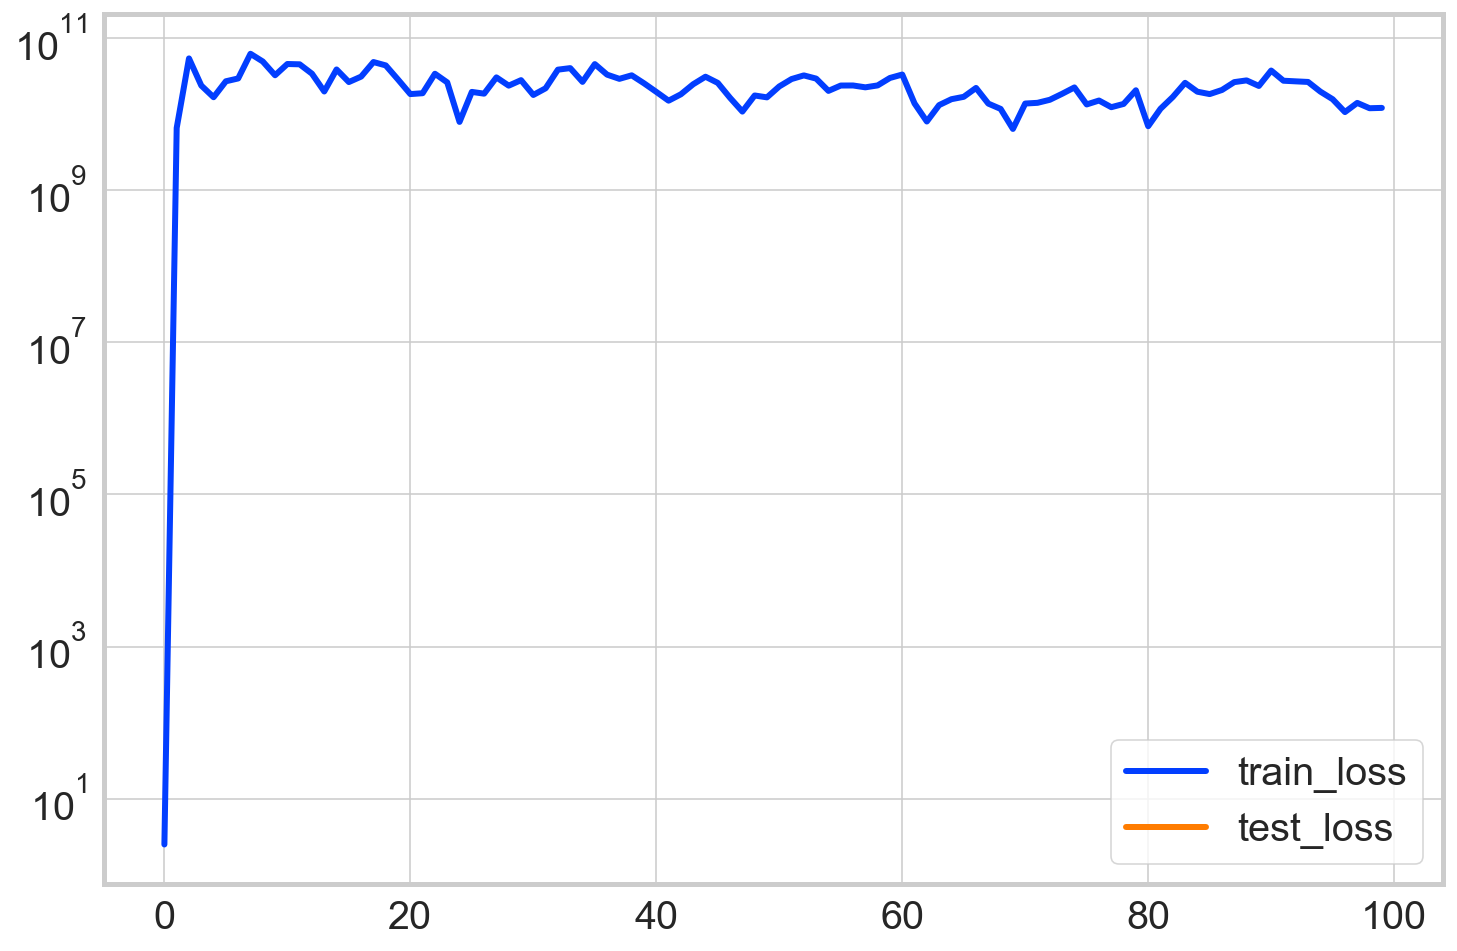

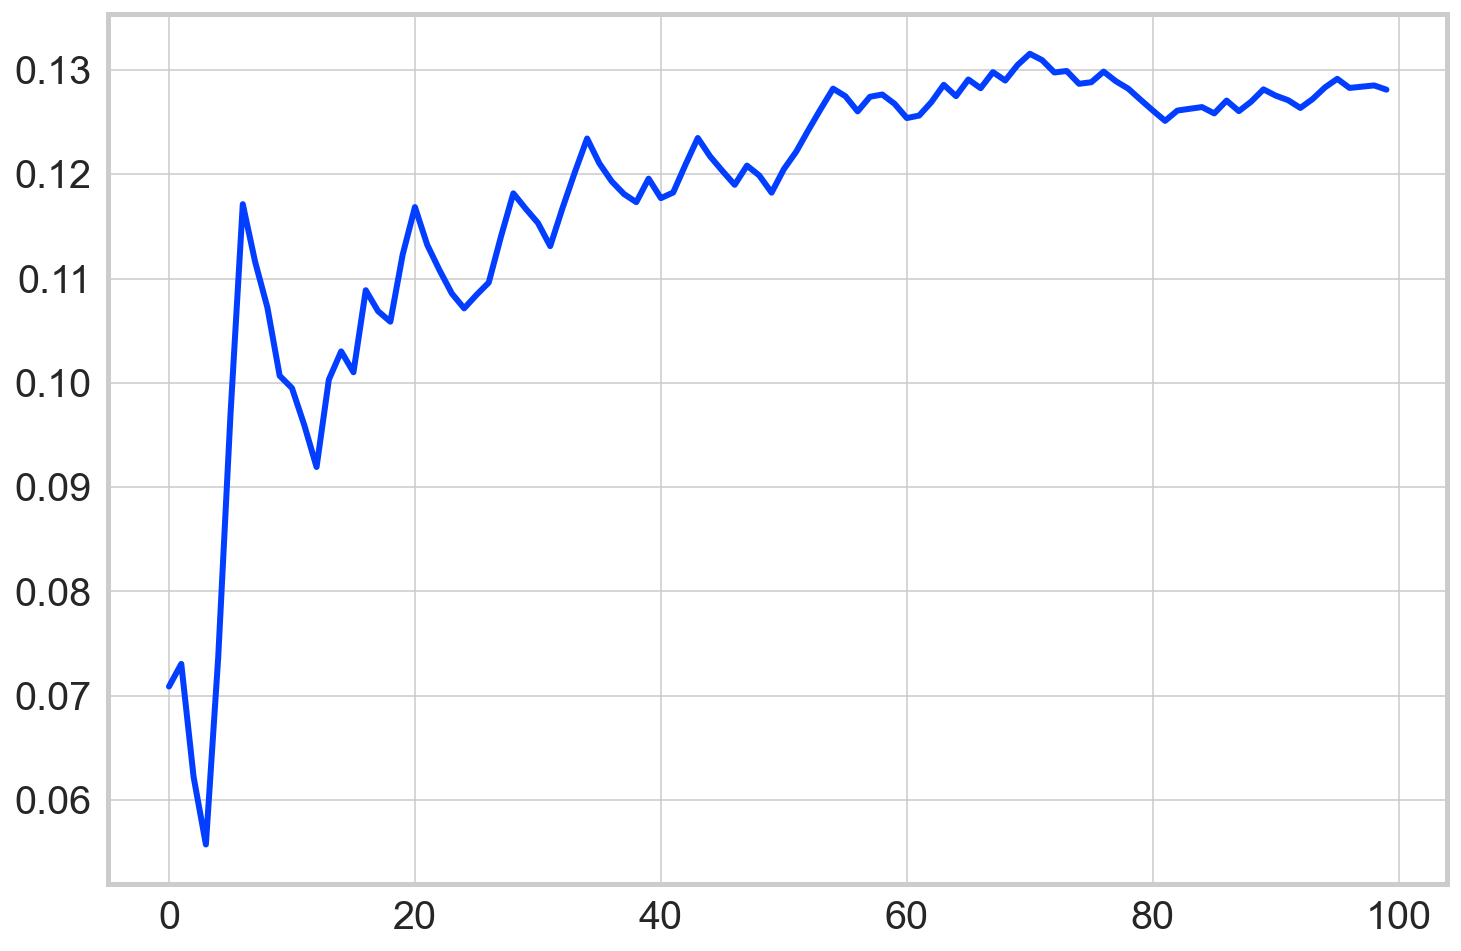

In [ ]:
for key in ['train_loss','test_loss']:
    plt.plot(stats[key],label=key)
plt.yscale('log')
plt.legend()
plt.show()

for key in ['train_acc','test_acc']:
    plt.plot(stats[key],label=key)
plt.show()